In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls

Mounted at /content/drive
drive  sample_data


In [2]:
# move into project directory
repo_name = "crop-damage-classification"
%cd /content/drive/MyDrive/Personal-Projects/$repo_name
!ls

/content/drive/MyDrive/Personal-Projects/crop-damage-classification
common	     dataloading  Index.ipynb  output		    project-structure.md  transforms
config.yaml  experiments  index.py     preprocess	    README.md		  visualization
data	     Index_bc.py  models       preprocess_input.py  run.yaml


In [3]:
# set up environment
# comment if not required
'''
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

'\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118\n!pip install matplotlib numpy pandas pyyaml opencv-python\n'

# Following cells are for downloading data

In [4]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder
# comment if not required
!pip install boto3
!pip install tqdm

In [4]:
# setup some imports
#custom imports
from transforms.transforms import ToTensor, Resize, CenterCrop
from dataloading.dataset import CropDataset
from common.utils import get_exp_params, init_config, get_config, save2config, get_modelinfo, get_saved_model
from models.resnet18 import Resnet18
from models.custom_models import get_model
from experiments.experiments import Experiment
from visualization.visualization import Visualization
from experiments.test_model import ModelTester

#py imports
import random
import numpy as np
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

In [6]:
import boto3
from pathlib import Path
from botocore import UNSIGNED
from botocore.client import Config
from tqdm.notebook import tqdm

def get_file_folders(s3_client, bucket_name, prefix=""):
    file_names = []
    folders = []

    default_kwargs = {
        "Bucket": bucket_name,
        "Prefix": prefix
    }
    next_token = ""

    while next_token is not None:
        updated_kwargs = default_kwargs.copy()
        if next_token != "":
            updated_kwargs["ContinuationToken"] = next_token

        response = s3_client.list_objects_v2(**updated_kwargs)
        contents = response.get("Contents")

        for result in contents:
            key = result.get("Key")
            if key[-1] == "/":
                folders.append(key)
            else:
                file_names.append(key)

        next_token = response.get("NextContinuationToken")

    return file_names, folders

def download_files(s3_client, bucket_name, local_path, file_names, folders):
    local_path = Path(local_path)

    for folder in tqdm(folders):
        folder_path = Path.joinpath(local_path, folder)
				# Create all folders in the path
        folder_path.mkdir(parents=True, exist_ok=True)

    for file_name in tqdm(file_names):
        file_path = Path.joinpath(local_path, file_name)
				# Create folder for parent directory
        file_path.parent.mkdir(parents=True, exist_ok=True)
        s3_client.download_file(
            bucket_name,
            file_name,
            str(file_path)
        )

data_path = 'data/input/images'
if not(os.path.exists(os.path.join(os.getcwd(), data_path))):
    client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    file_names, folders = get_file_folders(client, 'cgiar-crop-damage-classification-challenge')
    download_files(
        client,
        'cgiar-crop-damage-classification-challenge',
        "/content/drive/MyDrive/Personal-Projects/crop-damage-classification/data/input",
        file_names,
        folders
    )

In [5]:
# initialize directories and config data
init_config()
config = get_config()
print('Config parameters\n')
print(config)

Config parameters

{'X_key': 'image', 'data_dir': '/content/drive/MyDrive/Personal-Projects/crop-damage-classification/data', 'device': 'cpu', 'img_dir': '/content/drive/MyDrive/Personal-Projects/crop-damage-classification/data/input/images', 'output_dir': '/content/drive/MyDrive/Personal-Projects/crop-damage-classification/output', 'root_dir': '/content/drive/MyDrive/Personal-Projects/crop-damage-classification', 'use_gpu': False, 'y_key': 'label'}


In [6]:
# read experiment parameters
exp_params = get_exp_params()
print('Experiment parameters\n')
print(exp_params)

Experiment parameters

{'transform': {'resize_dim': 256, 'crop_dim': 224}, 'train': {'shuffle_data': True, 'batch_size': 128, 'val_split_method': 'k-fold', 'k': 2, 'val_percentage': 20, 'loss': 'cross-entropy', 'batch_interval': 512, 'epoch_interval': 1, 'num_epochs': 1}, 'model': {'name': 'resnet18', 'optimizer': 'Adam', 'lr': 0.001, 'weight_decay': 1e-05, 'amsgrad': False, 'momentum': 0.9}, 'test_model': False}


In [7]:
#initialize randomness seed
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [8]:
#preprocess data or load preprocessed data

#build label dict
label_dict = {
    'DR': 0,
    'G': 1,
    'ND': 2,
    'WD': 3,
    'other': 4
}

class_dict = {
    0: 'DR',
    1: 'G',
    2: 'ND',
    3: 'WD',
    4: 'other'
}

In [9]:
#save X_key and y_key
save2config('X_key', 'image')
save2config('y_key', 'label')

#transform data
data_transforms = transforms.Compose([ToTensor(), Resize(exp_params['transform']['resize_dim']), CenterCrop(exp_params['transform']['crop_dim'])])

#convert to dataset
ftr_dataset = CropDataset('input/Train.csv', label_dict, False, transforms=data_transforms)
test_dataset = CropDataset('input/Test.csv', label_dict, True, transforms=data_transforms)
smlen = int(0.01 * len(ftr_dataset))
smftr_dataset = torch.utils.data.Subset(ftr_dataset, list(range(smlen)))
print('Full train dataset length:', len(ftr_dataset))
print('Test dataset length:', len(test_dataset))
print('Subset train dataset length:', smlen, '\n')



Full train dataset length: 26068
Test dataset length: 8663
Subset train dataset length: 260 



In [15]:
#running experiment on small subset of the dataset
exp = Experiment(exp_params['model']['name'], smftr_dataset)
model_history = exp.train()

if
Running split 0
130 130
	Running Epoch 0
		Running through training dataset


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


		Running through validation set
Epoch 0 Training Loss: 1.5901374450096717
Epoch 0 Validation Loss: 229.34571345402645
Epoch 0 Validation Accuracy: 0.03076923079788685



In [ ]:
'''
#model training on full dataset
exp = Experiment(exp_params['model']['name'], ftr_dataset)
model_history = exp.train()
'''


Model validation results
[1.5901374816894531]

Best model results




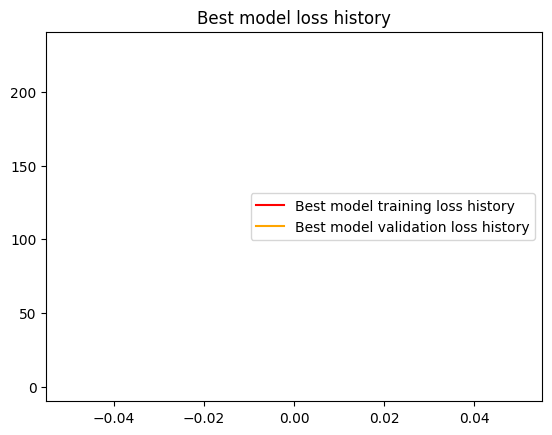

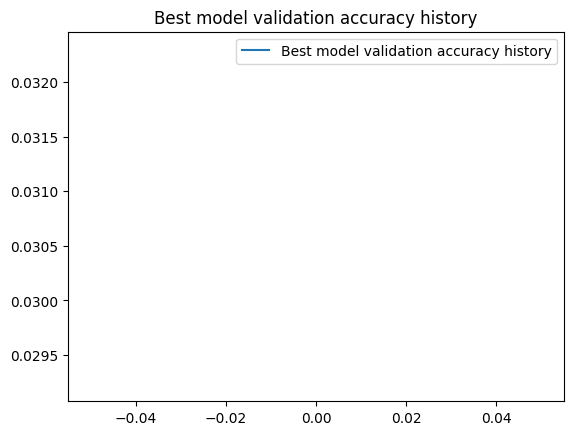


Best Model Training Loss: 1.5901374450096717
Best Model Validation Loss: 229.34571345402645
Best Model Accuracy: 0.03076923079788685



In [11]:
# get best model
model = get_model(exp_params["model"]["name"])
model = get_saved_model(model, '')
model_info = get_modelinfo('')

print("\nModel validation results")
print(model_info['results']['trlosshistory'])
#visualization results
vis = Visualization(model_info, model_history)
vis.get_results()

In [26]:
#model testing
print("\n\nTesting Saved Model")
mt = ModelTester(model, test_dataset)
mt.test_and_save_csv(class_dict)



Testing Saved Model
4992
4864 38
Running through test dataset


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	Running through batch 0
in else
	Running through batch 1
in else
	Running through batch 2
in else
	Running through batch 3
in else
	Running through batch 4
in else
	Running through batch 5
in else
	Running through batch 6
in else
	Running through batch 7
in else
	Running through batch 8
in else
	Running through batch 9
in else
	Running through batch 10
in else
	Running through batch 11
in else
	Running through batch 12
in else
	Running through batch 13
in else
	Running through batch 14
in else
	Running through batch 15
in else
	Running through batch 16
in else
	Running through batch 17
in else
	Running through batch 18
in else
	Running through batch 19
in else
	Running through batch 20
in else
	Running through batch 21
in else
	Running through batch 22
in else
	Running through batch 23
in else
	Running through batch 24
in else
	Running through batch 25
in else
	Running through batch 26
in else
	Running through batch 27
in else
	Running through batch 28
in else
	Running through batch 2

<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 39
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 40
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 41
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 42
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 43
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 44
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 45
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 46
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 47
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 48
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 49
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 50
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 51
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 52
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 53
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies i

torch.Size([128, 5])
torch.Size([128])
	Running through batch 54
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)


torch.Size([128, 5])
torch.Size([128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	Running through batch 55
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)


torch.Size([128, 5])
torch.Size([128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	Running through batch 56
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)


torch.Size([128, 5])
torch.Size([128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	Running through batch 57
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)


torch.Size([128, 5])
torch.Size([128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	Running through batch 58
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)


torch.Size([128, 5])
torch.Size([128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	Running through batch 59
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)


torch.Size([128, 5])
torch.Size([128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	Running through batch 60
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)


torch.Size([128, 5])
torch.Size([128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	Running through batch 61
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)


torch.Size([128, 5])
torch.Size([128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	Running through batch 62
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)


torch.Size([128, 5])
torch.Size([128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	Running through batch 63
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)


torch.Size([128, 5])
torch.Size([128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	Running through batch 64
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)


torch.Size([128, 5])
torch.Size([128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	Running through batch 65
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)


torch.Size([128, 5])
torch.Size([128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	Running through batch 66
inside if


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)


torch.Size([128, 5])
torch.Size([128])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


	Running through batch 67
inside if
torch.Size([87, 5])
torch.Size([87])


<ipython-input-25-086635ddb758>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.softmax(self.model(batch[self.X_key].float()))
<ipython-input-25-086635ddb758>:88: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  results_df = pd.concat([results_df, batch_df], 0)
